In [1]:
from nba_api.stats.static import players
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
from nba_api.stats.endpoints import shotchartdetail
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg


# Récupère les joueurs actifs
players_list = players.get_active_players()
df_players = pd.DataFrame(players_list)
# Par exemple, récupérer l'ID de LeBron James
lebron = [player for player in players_list if player['full_name'] == 'Stephen Curry'][0]
player_id = lebron['id']


In [2]:
from nba_api.stats.endpoints import shotchartdetail

player_id = 201939  # LeBron James
season = "2024-25"
team_id = 0  # Mets 0 si tu veux tous les tirs (ou cherche le bon team_id)

shotchart = shotchartdetail.ShotChartDetail(
    team_id=team_id,
    player_id=player_id,
    season_type_all_star='Regular Season',
    season_nullable=season,
    context_measure_simple='FGA'
)

df_shots = shotchart.get_data_frames()[0]
df_shots = df_shots[df_shots['EVENT_TYPE'] == 'Made Shot'].copy()


In [3]:
df_shots.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0022400007,12,201939,Stephen Curry,1610612744,Golden State Warriors,1,11,28,...,Left Side Center(LC),24+ ft.,25,-199,157,1,1,20241112,GSW,DAL
1,Shot Chart Detail,0022400007,37,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,14,...,Center(C),Less Than 8 ft.,3,-34,15,1,1,20241112,GSW,DAL
3,Shot Chart Detail,0022400007,94,201939,Stephen Curry,1610612744,Golden State Warriors,1,6,22,...,Left Side Center(LC),24+ ft.,31,-175,264,1,1,20241112,GSW,DAL
5,Shot Chart Detail,0022400007,128,201939,Stephen Curry,1610612744,Golden State Warriors,1,4,7,...,Right Side Center(RC),16-24 ft.,20,161,120,1,1,20241112,GSW,DAL
7,Shot Chart Detail,0022400007,148,201939,Stephen Curry,1610612744,Golden State Warriors,1,2,14,...,Center(C),16-24 ft.,18,-25,183,1,1,20241112,GSW,DAL


In [4]:
# 🎨 2. Fonction de tracé du terrain NBA
def draw_court(ax=None, color='white', lw=2, outer_lines=False):
    if ax is None:
        ax = plt.gca()

    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)
    paint = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color, fill=False)
    free_throw = Circle((0, 142.5), 60, linewidth=lw, color=color, fill=False)
    free_throw_top = Arc((0, 142.5), 120, 120, theta1=0, theta2=180, color=color, lw=lw)
    free_throw_bottom = Arc((0, 142.5), 120, 120, theta1=180, theta2=0, color=color, lw=lw, linestyle='dashed')
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, color=color, lw=lw)
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw, color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, color=color, lw=lw)
    center_circle = Circle((0, 422.5), 60, linewidth=lw, color=color, fill=False)

    court_elements = [
        hoop, backboard, paint, free_throw, free_throw_top, free_throw_bottom,
        restricted, corner_three_a, corner_three_b, three_arc, center_circle
    ]
    for element in court_elements:
        ax.add_patch(element)

    ax.set_xlim(-250, 250)
    ax.set_ylim(-50, 470)
    ax.axis('off')


In [5]:
# 🎯 3. Calcul de l'efficacité par hexagone
hexbin = plt.hexbin(
    df_shots['LOC_X'],
    df_shots['LOC_Y'],
    gridsize=30,
    extent=(-250, 250, -50, 470),
    cmap='coolwarm',
    bins='log'
)
plt.clf()  # On vide le buffer du premier hexbin


<Figure size 640x480 with 0 Axes>

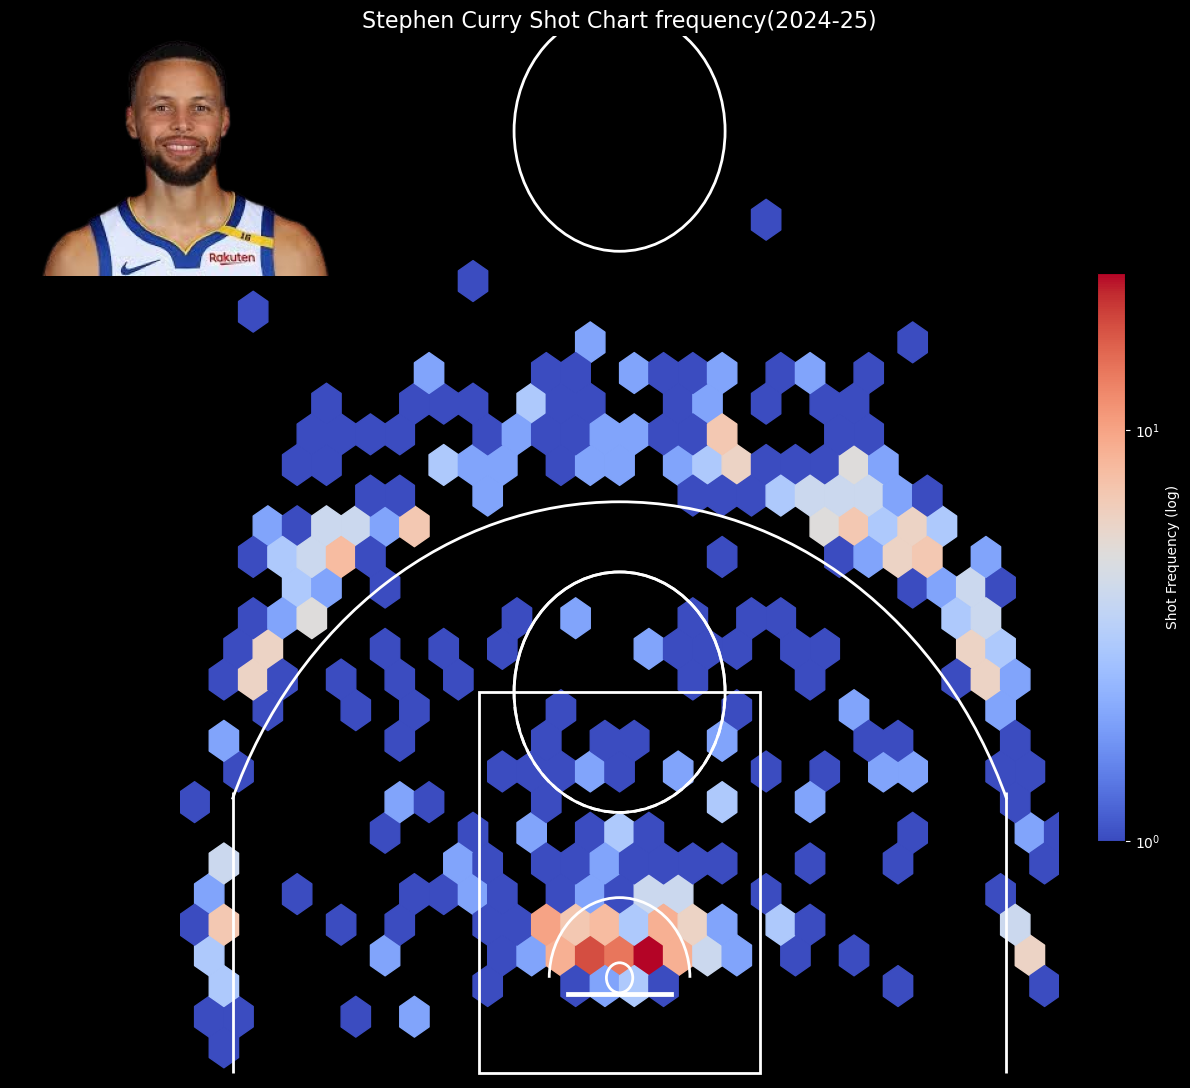

In [6]:
# 🎨 4. Visualisation
fig, ax = plt.subplots(figsize=(12, 11), facecolor='black')
hb = ax.hexbin(
    df_shots['LOC_X'],
    df_shots['LOC_Y'],
    gridsize=30,
    extent=(-250, 250, -50, 470),
    cmap='coolwarm',
    bins='log'
)

draw_court(ax, color='white')
ax.set_facecolor('black')
cb = fig.colorbar(hb, ax=ax, fraction=0.03, pad=0.04)
cb.set_label('Shot Frequency (log)', color='white')
cb.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='white')

# 📸 Charger l'image
img_path = 'Curry.png'  # Remplace par le chemin de ton image
img = mpimg.imread(img_path)
imagebox = OffsetImage(img, zoom=0.9)  # ajuste le zoom selon la taille de l'image

# 📍 Positionner l’image (ex: en haut à gauche)
ab = AnnotationBbox(imagebox, (-250, 410), frameon=False)
ax.add_artist(ab)

ax.set_title("Stephen Curry Shot Chart frequency(2024-25)", color='white', fontsize=16)
plt.tight_layout()
plt.show()


In [7]:
fig.savefig('LeBron James Shot Chart frequency.png', bbox_inches='tight')